In [1]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import mne
import numpy as np
from tqdm import tqdm
import re
from multiprocessing import Pool
import warnings

warnings.filterwarnings("ignore")

os.chdir('../..')

# Load All The Exec Blocks

In [2]:
from Scripts.Data_Loader import EIRDataset

EIR_Dataset = EIRDataset('./Generated/Data_Train/', task_type='all', n_jobs=72) # task type can be `geometric` or `random` or `all`

# Get the sample of data
for i in range(len(EIR_Dataset)): 
    eeg_sample, eye_sample, metadata, label, img = EIR_Dataset[i]
    print(f"EEG sample len is: {len(eeg_sample)}")
    break

Loading .fif files: 100%|██████████| 651/651 [00:13<00:00, 46.72it/s]


EEG sample len is: 16001


# Compute Morlet Wavelet Spectrums for Execution Blocks 
As a result, produces:
* `psds_array` - list of psds morlet wavelet spectras
* `metadata`   - list of [`sub_id`, `trial_id`, `gender`, `handiness`, `age`, ...] 

### Get the subjects info
Will be usefull to pack ones for spectrums 

In [3]:
from datetime import datetime

# --- 1) Читаем Excel, пропуская первую строку «слитного» заголовка ---
file_path = './Supplementary/Experiment_Metadata.xlsx'
df_raw = pd.read_excel(file_path, header=1)

# --- 2) Переименовываем нужные колонки ---
df_raw = df_raw.rename(columns={
    'Subject ID'         : 'Subject_id',
    'Имя'                : 'Name',
    'Фамилия'            : 'Surname',
    'Дата Рождения'      : 'Birthdate',
    'Пол'                : 'Gender',
    'Правша / Левша'     : 'Handiness',
})

# --- 3) Оставляем только нужные поля, включая Handiness ---
df = df_raw[['Subject_id', 'Name', 'Surname', 'Birthdate', 'Gender', 'Handiness']].copy()

# --- 4) Преобразуем «Пол» из кириллицы в латинскую букву m/f ---
gender_map = {'М': 'm', 'Ж': 'f'}
df['Gender'] = df['Gender'].map(gender_map)

# --- 5) Преобразуем «Handiness» в r/l ---
# Предполагаем, что в файле пишется именно «Правша» или «Левша»
hand_map = {'Правша': 'r', 'Левша': 'l'}
df['Handiness'] = df['Handiness'].map(hand_map)

# --- 6) Переводим «Дата Рождения» в datetime ---
df['Birthdate'] = pd.to_datetime(df['Birthdate'], dayfirst=True, errors='coerce')

# --- 7) Считаем возраст в годах (целое число) ---
today = datetime.today()
def calculate_age(birth_dt):
    if pd.isna(birth_dt):
        return None
    years = today.year - birth_dt.year
    if (today.month, today.day) < (birth_dt.month, birth_dt.day):
        years -= 1
    return int(years)

df['Age'] = df['Birthdate'].apply(calculate_age)

# --- 8) Заменяем NaN в Age на 0, превращая колонку в целочисленную ---
df['Age'] = df['Age'].fillna(0).astype(int)

# --- 9) Удаляем колонку Birthdate, она больше не нужна ---
df = df.drop(columns=['Birthdate'])

# --- 10) Делаем Subject_id индексом ---
subject_metadata = df.set_index('Subject_id')

subject_metadata

,Name,Surname,Gender,Handiness,Age
Subject_id,,,,,
1,Софья,Гамершмидт,f,r,21
2,Сергей,Пешков,m,r,19
3,Рувшан,Давлитшин,m,r,18
4,Мухаббат,Давлатова,f,r,30
5,Камиль,Фоатов,m,r,0
6,Алия,Хадеева,f,r,18
7,Алёна,Петренко,f,r,19
8,Умар,Магомедов,m,r,18
9,Мария,Мельникова,f,r,31


### Compute and Save Morlet Spectras (PSD)

In [4]:
import numpy as np
from mne.time_frequency import tfr_array_morlet
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Морле параметры вынесем отдельно
freqs = np.linspace(2, 40, 39*5)   # частотное разрешение 0.2Hz
n_cycles = freqs / 2.0
decim = 50                         # времянное разрешение 50мс
n_jobs = 1
n_workers = 72

def process_sample(args):
    eeg, metadata, label, img = args

    subj = metadata['subject_id']
    trial = metadata['trial_id']
    task_type = metadata['task_type']

    gender    = subject_metadata.loc[subj, 'Gender']
    handiness = subject_metadata.loc[subj, 'Handiness']
    age       = subject_metadata.loc[subj, 'Age']

    # Данные
    data = eeg.get_data()
    data_reshaped = data[np.newaxis, :, :]

    # Морле спектр с комплексным выходом
    W = tfr_array_morlet(
        data_reshaped,
        sfreq=eeg.info['sfreq'],
        freqs=freqs,
        n_cycles=n_cycles,
        output='complex',
        decim=decim,
        n_jobs=n_jobs,
        verbose=False
    )

    W = W.squeeze()  # → (n_channels, n_freqs, n_times)

    # Выделяем амплитуду и фазу
    power = np.abs(W).astype(np.float32) ** 2
    phase = np.angle(W).astype(np.float32)

    # power = power.squeeze()  # (n_channels, n_freqs, n_times)

    return [power, phase, subj, trial, gender, handiness, age, label, img, task_type]

# Подготовим список аргументов
dataset_args = [(eeg, metadata, label, img) for (eeg, _, metadata, label, img) in EIR_Dataset]

# Параллельный запуск
with Pool(processes=n_workers) as pool:
    results_arr = list(tqdm(pool.imap(process_sample, dataset_args), total=len(dataset_args)))

results_arr[0][0].shape

100%|██████████| 651/651 [01:20<00:00,  8.12it/s]


(63, 195, 321)

In [5]:
save_dict = {}
for i, entry in enumerate(results_arr):
    power, phase, s_id, t_id, gender, handiness, age, label, img, task_type = entry
    save_dict[f'power_{i}'] = power       # (ch, freq, time)
    save_dict[f'phase_{i}'] = phase   # (ch, freq, time)
    save_dict[f'subject_id_{i}'] = np.array(s_id)
    save_dict[f'trial_id_{i}'] = np.array(t_id)
    save_dict[f'gender_{i}'] = np.array(gender, dtype='U1')
    save_dict[f'handiness_{i}']  = np.array(handiness, dtype='U1')
    save_dict[f'age_{i}'] = np.array(age, dtype=int)
    save_dict[f'label_{i}']  = np.array(label, dtype=int)
    save_dict[f'img_{i}'] = np.array(img, dtype=int)
    save_dict[f'task_type_{i}'] = np.array(task_type, dtype='U1')

# Сохраняем в .npz
np.savez('./Generated/Spectrums/exec_morlets.npz', **save_dict)

### Visualizations (Optional)
* Morlet spectrums with automatic pattern detection
* Plot all morlets channel averaged

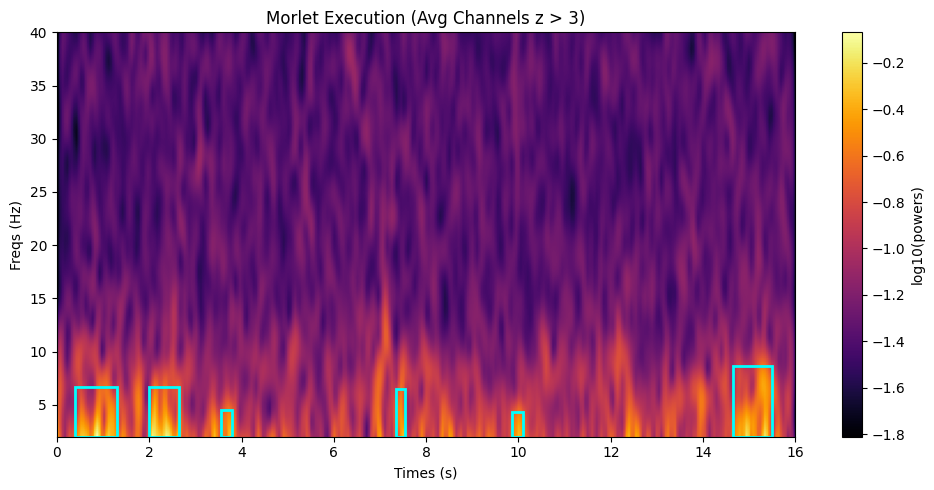

In [6]:
from scipy.ndimage import label, find_objects
from matplotlib.patches import Rectangle

power, phase, s_id, t_id, gender, handiness, age, label_val, img, task_type = results_arr[0]

def detect_power_patterns_avg(psd_all_channels, freqs, times, z_thresh=2.0, min_dur=0.1):
    """
    Детектирует паттерны на спектрограмме, усреднённой по каналам.
    Возвращает список словарей с координатами паттернов.
    """
    # Усреднение по каналам → (195, 309)
    psd_mean = np.mean(psd_all_channels, axis=0)
    log_power = np.log10(psd_mean + 1e-10)

    # Z-преобразование
    z_map = (log_power - np.mean(log_power)) / np.std(log_power)
    mask = z_map > z_thresh

    labeled, num = label(mask)
    objects = find_objects(labeled)

    patterns = []
    for sl in objects:
        f_start, t_start = sl[0].start, sl[1].start
        f_end, t_end = sl[0].stop, sl[1].stop

        # Длительность по времени (в секундах)
        dur = (t_end - t_start) * (times[1] - times[0])
        if dur < min_dur:
            continue

        patterns.append({
            'freq_low': freqs[f_start],
            'freq_high': freqs[f_end - 1],
            'time_start': times[t_start],
            'time_end': times[t_end - 1],
        })

    return log_power, patterns

    

def plot_avg_spectrogram_with_patterns(psd, freqs, times, z_thresh=2.0, min_dur=0.1):
    log_power, patterns = detect_power_patterns_avg(psd, freqs, times, z_thresh, min_dur)

    plt.figure(figsize=(10, 5))
    plt.imshow(log_power, aspect='auto', origin='lower',
               extent=[times[0], times[-1], freqs[0], freqs[-1]],
               cmap='inferno')
    plt.colorbar(label='log10(powers)')
    plt.xlabel('Times (s)')
    plt.ylabel('Freqs (Hz)')
    plt.title(f'Morlet Execution (Avg Channels z > {z_thresh})')

    for pat in patterns:
        rect = Rectangle(
            (pat['time_start'], pat['freq_low']),
            pat['time_end'] - pat['time_start'],
            pat['freq_high'] - pat['freq_low'],
            linewidth=2,
            edgecolor='cyan',
            facecolor='none'
        )
        plt.gca().add_patch(rect)

    plt.tight_layout()
    plt.show()


    
freqs = np.linspace(2, 40, 39*5)
times = np.arange(power.shape[2]) * 50 / 1000

plot_avg_spectrogram_with_patterns(power, freqs, times, z_thresh=3, min_dur=0.2)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_subject_trials(results_arr, target_s_id, target_t_id):
    # 1. Отфильтровать блоки для нужного субъекта и задания
    filtered = [entry[0] for entry in results_arr if entry[2] == target_s_id and entry[3] == target_t_id]

    # 2. Параметры осей
    freqs = np.linspace(2, 40, 195)
    times = np.arange(309) * 50 / 1000   # или свой decim

    n_blocks = len(filtered)
    n_cols = 3
    n_rows = int(np.ceil(n_blocks / n_cols))

    # 3. Фигура
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, psd in enumerate(filtered):
        # Усреднение по каналам → (195, 309)
        avg_psd = np.mean(psd, axis=0)
        log_psd = np.log10(avg_psd + 1e-10)

        ax = axes[i]
        im = ax.imshow(log_psd, aspect='auto', origin='lower',
                       extent=[times[0], times[-1], freqs[0], freqs[-1]],
                       cmap='inferno')
        ax.set_title(f'Execution {i+1}')
        ax.set_xlabel('time(s)')
        ax.set_ylabel('freqs (Hz)')

    # 4. Удалим лишние оси, если блоков < n_rows * n_cols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 5. Цветовая шкала
    cbar_ax = fig.add_axes([1.05, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='log10(powers)')

    plt.suptitle(f'Morlet Execution (Avg Channels):  S{target_s_id} T{target_t_id}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f'./Generated/Figures/Spectral_Analysis/Execution/Morlet_S{target_s_id}_T{target_t_id}.png', dpi=300)
    plt.close()


for i in tqdm(range(1, 17)):
    if i == 14:
        plot_subject_trials(results_arr, target_s_id=i, target_t_id=1)
    else:
        plot_subject_trials(results_arr, target_s_id=i, target_t_id=1)
        plot_subject_trials(results_arr, target_s_id=i, target_t_id=2)

100%|██████████| 16/16 [04:01<00:00, 15.09s/it]
